<a href="https://colab.research.google.com/github/GHMelany/AMD_project/blob/main/AMD%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJECT: Link Ananlysis



LIBRARIES

In [5]:
!pip install langid


In [6]:
!pip uninstall -y pyspark
!apt-get update
!pip install pyspark==3.4.1
!apt-get install openjdk-8-jdk -y
!mkdir -p jars
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar -P jars
!pip install graphframes

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 19.2 MB/s 

In [7]:
# =======================
# SETUP AND CONFIGURATION
# =======================

import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, collect_set, explode
from pyspark.sql.types import ArrayType, StringType
from itertools import combinations
import matplotlib.pyplot as plt

def start_spark(app_name="BookLinkPageRank"):
    """
    Start a SparkSession with GraphFrames support.
    """
    spark = SparkSession.builder \
        .appName(app_name) \
        .config("spark.jars", "jars/graphframes-0.8.2-spark3.0-s_2.12.jar") \
        .getOrCreate()
    return spark

def set_java_home():
    """
    Set JAVA_HOME environment variable to use Java 8.
    """
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [8]:
# =========================
# DATA LOADING AND CLEANING
# =========================

def load_books_data(spark, rating_path, data_path, sample_fraction=0.05, seed=42):
    """
    Load and clean book ratings and metadata.
    """
    # Load user-book ratings
    df = spark.read.csv(rating_path, header=True, inferSchema=True, quote='"', escape='"')
    df = df.select("User_id", "Title").dropna().dropDuplicates()
    df = df.withColumnRenamed("User_id", "user_id") \
           .withColumnRenamed("Title", "title") \
           .sample(fraction=sample_fraction, seed=seed)

    # Load book metadata
    books_data = spark.read.csv(data_path, header=True, inferSchema=True, quote='"', escape='"')
    return df, books_data


In [9]:
# =======================
# GRAPH CONSTRUCTION
# =======================

def generate_book_pairs_udf():
    """
    UDF to generate all unique book pairs from a set of books.
    """
    from pyspark.sql.functions import udf
    def generate_pairs(books):
        return list(combinations(sorted(books), 2))
    return udf(generate_pairs, ArrayType(ArrayType(StringType())))

def build_graph(df):
    """
    Build a GraphFrame from user-book interactions.
    """
    # Group books by user
    user_books = df.groupBy("user_id") \
                   .agg(collect_set("title").alias("books"))

    # Generate book pairs
    pair_udf = generate_book_pairs_udf()
    book_pairs = user_books.withColumn("pairs", pair_udf("books")) \
                           .select("pairs") \
                           .withColumn("pair", explode("pairs")) \
                           .selectExpr("pair[0] as src", "pair[1] as dst")

    # Create edges with weight (co-occurrence count)
    edges = book_pairs.groupBy("src", "dst") \
                      .agg(count("*").alias("weight")) \
                      .filter(col("weight") >= 2)

    # Create vertices
    vertices = edges.select("src").withColumnRenamed("src", "id") \
                    .union(edges.select("dst").withColumnRenamed("dst", "id")) \
                    .distinct()

    from graphframes import GraphFrame
    g = GraphFrame(vertices, edges)
    return g

In [10]:
# =======================
# PAGERANK AND ANALYSIS
# =======================

def compute_pagerank(graph, max_iter=10, reset_prob=0.15):
    """
    Run PageRank algorithm on the graph.
    """
    return graph.pageRank(resetProbability=reset_prob, maxIter=max_iter)

def enrich_with_book_info(pagerank_df, books_data):
    """
    Join PageRank results with book metadata.
    """
    return pagerank_df.withColumnRenamed("id", "title") \
                      .join(books_data, on="title", how="left")

In [11]:
# =======================
# VISUALIZATION
# =======================

def plot_top_books(df, top_n=10):
    """
    Plot top N books ranked by PageRank.
    """
    top_books_pd = df.select("title", "pagerank") \
                     .orderBy(col("pagerank").desc()) \
                     .limit(top_n) \
                     .toPandas()

    plt.figure(figsize=(10,6))
    plt.barh(top_books_pd['title'], top_books_pd['pagerank'])
    plt.xlabel("PageRank")
    plt.title(f"Top {top_n} most central books by PageRank")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 98% 1.04G/1.06G [00:04<00:00, 269MB/s]
100% 1.06G/1.06G [00:05<00:00, 227MB/s]


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


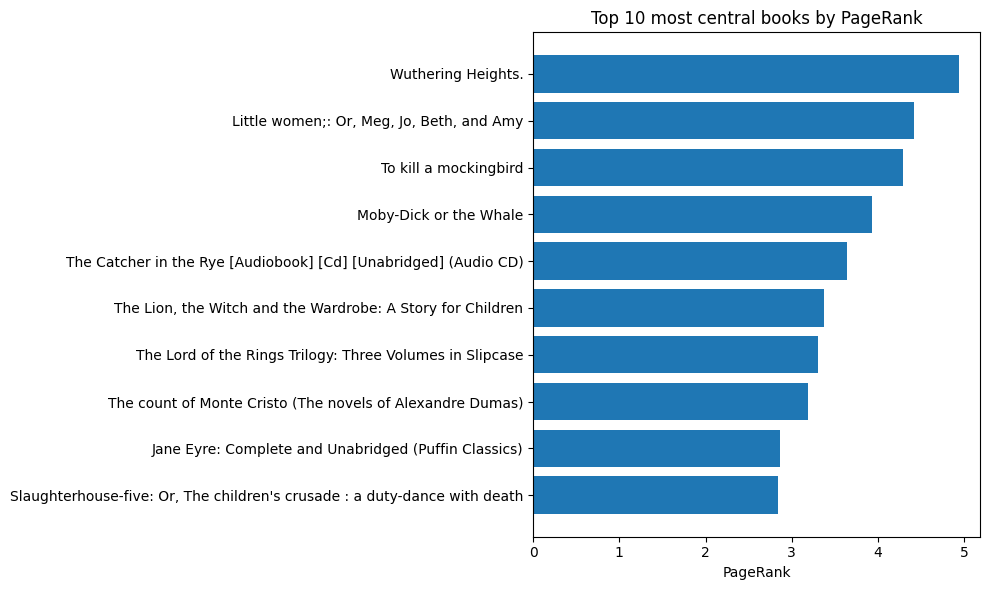

In [12]:
# =======================================
# DATA ACQUISITION AND PIPELINE EXECUTION
# =======================================


import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxx"

!pip install -q kaggle

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

import zipfile
zip_path = "amazon-books-reviews.zip"
extract_dir = "amazon_books_reviews"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

folder = "amazon_books_reviews"
csv_path = os.path.join(folder, "Books_rating.csv")
data_path = os.path.join(folder, "books_data.csv")

# Run the main pipeline
set_java_home()
spark = start_spark()

ratings_df, books_data_df = load_books_data(spark, csv_path, data_path)
graph = build_graph(ratings_df)
results = compute_pagerank(graph)
ranked_books = enrich_with_book_info(results.vertices, books_data_df)
plot_top_books(ranked_books, top_n=10)
